In [15]:
#%% Import
import sys
sys.path.append("/home/jan/Documents/ETH/Masterarbeit/climada_python")
import numpy as np
import netCDF4 as nc
import xarray as xr
import pandas as pd
import geopandas as gpd
from climada.hazard import Hazard
from scipy import sparse
import copy as cp
from matplotlib import pyplot as plt
from climada.entity import Exposures, Entity, LitPop
from climada.entity import ImpactFuncSet, ImpactFunc
from climada.engine import Impact
import h5py
import hail_functions as fct
from sklearn.metrics import mean_squared_error
from scipy import optimize
import time
from scipy import stats
from scipy.stats import spearmanr
from climada.entity.tag import Tag

In [16]:
#%% Parameter
# If any value in force_new_hdf5_generation is True the script will ask for 
# user input wether to overwrite the hdf5 with the new data
force_new_hdf5_generation ={"haz_real": False, 
                            "haz_synth": False, 
                            "haz_dur": False,
                            "exp_infr": False, 
                            "exp_agr": False}
name_hdf5_file={"haz_real": "haz_real.hdf5", 
                "haz_synth": "haz_synth.hdf5", 
                "haz_dur": "haz_dur.hdf5",
                "exp_infr": "exp_switzerland.hdf5", 
                "exp_agr": "exp_agr.hdf5"}

# Optimization
plot_img = False  #Takes a lot of time if True
haz_type = "HL"
ev_list = ["12/07/2011", "13/07/2011"]#["01/07/2019", "02/07/2019", "18/08/2019", "06/08/2019", "30/06/2019", "15/06/2019"]#, "01/07/2019", "18/06/2019"]

imp_fun_grape = {"imp_id": 2, "L": 0.8, "x_0": 35, "k": 10}
imp_fun_fruit = {"imp_id": 3, "L": 1.0, "x_0": 80, "k": 10}
imp_fun_agriculture = {"imp_id": 4, "L": 0.5, "x_0": 50, "k": 10}
imp_fun_dur_grape = {"imp_id": 5, "L": 0.8, "x_0": 50, "k": 1}
imp_fun_dur_fruit = {"imp_id": 6, "L": 1.0, "x_0": 50, "k": 1}
imp_fun_dur_agriculture = {"imp_id": 7, "L": 0.5, "x_0": 50, "k": 1}

imp_fun_parameter = [imp_fun_grape,
                     imp_fun_fruit,
                     imp_fun_agriculture,
                     imp_fun_dur_grape, 
                     imp_fun_dur_fruit, 
                     imp_fun_dur_agriculture]
# Path to Data 
input_folder = "/home/jan/Documents/ETH/Masterarbeit/input"
results_folder = "~/Documents/ETH/Masterarbeit/results"
years =["2002", "2003", "2004","2005", "2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018","2019"]
years_synth = ["1979", "1980", "1981", "1982", "1983", "1984", "1985", "1986", "1987", "1988", "1989", "1990", "1991", "1992", "1993", "1994", "1995", "1996", "1997", "1998", "1999", "2000", "2001" ,"2002", "2003", "2004","2005", "2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018","2019"]


# Parsimonious Impact model for agriculture

In [17]:
#%% Hazard
haz_real = fct.load_haz(force_new_hdf5_generation, "haz_real", name_hdf5_file, input_folder, years)
# haz_synth = fct.load_haz(force_new_hdf5_generation, "haz_synth", name_hdf5_file, input_folder, years_synth)
haz_dur = fct.load_haz(force_new_hdf5_generation, "haz_dur", name_hdf5_file, input_folder, years)
haz_dur.intensity = haz_dur.intensity.astype(dtype = int)
haz_real.check()
# haz_synth.check()
if plot_img:
    haz_real.plot_fraction(0)
    haz_real.plot_intensity(0)
    haz_real.plot_fraction(-1)
    haz_real.plot_intensity(-1)
    haz_real.plot_rp_intensity(return_periods=(1, 5, 10, 20))
    haz_dur.plot_fraction(0)
    haz_dur.plot_intensity(0)
    haz_dur.plot_fraction(-1)
    haz_dur.plot_intensity(-1)
    haz_dur.plot_rp_intensity(return_periods=(1, 5, 10, 20))

2021-03-29 11:46:15,441 - climada.hazard.base - INFO - Reading /home/jan/Documents/ETH/Masterarbeit/input/haz_real.hdf5
2021-03-29 11:46:15,694 - climada.hazard.base - INFO - Reading /home/jan/Documents/ETH/Masterarbeit/input/haz_dur.hdf5


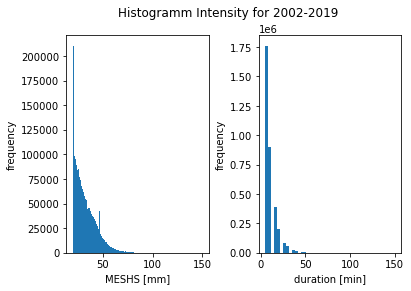

In [8]:
#hist:
%matplotlib inline
hist_dur = np.array([])
hist_meshs = np.array([])
for i in range(3294):
    hist_dur_temp = np.array(haz_dur.intensity[i].todense())[0]
    hist_dur_temp = hist_dur_temp[(hist_dur_temp != 0) & (hist_dur_temp <= 151)]
    hist_dur = np.append(hist_dur, hist_dur_temp)
    hist_meshs_temp = np.array(haz_real.intensity[i].todense())[0]
    hist_meshs_temp = hist_meshs_temp[(hist_meshs_temp != 0) & (hist_meshs_temp <= 151)]
    hist_meshs = np.append(hist_meshs, hist_meshs_temp)
# unique, counts = np.unique(hist_dur, return_counts=True)
# frequencies = np.asarray((unique, counts)).T
fig, axs = plt.subplots(1,2, sharey=False, tight_layout = False)
fig.suptitle("Histogramm Intensity for 2002-2019")
axs[1].hist(hist_dur, bins = 44)
axs[1].set(xlabel = "Duration [min]", ylabel = "frequency")
plt.xlabel("duration [min]")
plt.ylabel("frequency")
axs[0].hist(hist_meshs, bins = 125)
axs[0].set(xlabel = "MESHS [mm]", ylabel = "frequency")
fig.subplots_adjust(wspace = 0.35)


In [27]:
#%% Impact_functionse
# Set impact function (see tutorial climada_entity_ImpactFuncSet)
ifset_hail = ImpactFuncSet()
imp_fun = fct.create_impact_func(haz_type, #imp fun for Meshs
                             10, #id
                             1, 
                             1, 
                             1, 
                             y = None)
imp_fun.mdd[:] = 0.022 #Rewrite Impact function to be constant
ifset_hail.append(imp_fun)

imp_fun = fct.create_impact_func(haz_type, #imp fun for Dur
                             9, #id
                             1, 
                             1, 
                             1, 
                             y = None)
imp_fun.mdd[:] = 0.011 #Rewrite Impact function to be constant
ifset_hail.append(imp_fun)


2021-03-29 11:49:02,680 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 11:49:02,683 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


In [28]:
exp_meshs = fct.load_exp_agr(force_new_hdf5_generation, name_hdf5_file, input_folder, haz_real)
exp_dur = exp_meshs.copy()
exp_dur["if_HL"] = exp_dur["if_HL"]+3 #change if_HL to match the corresponding imp_id
if plot_img:
    exp_meshs.tag = Tag(file_name = "exp_agr", description="Exposure_description")
    exp_meshs.plot_basemap()
    exp_meshs.plot_hexbin()
    exp_meshs.plot_scatter()
    exp_meshs.plot_raster(raster_res = 0.001)

2021-03-29 11:49:03,788 - climada.entity.exposures.base - INFO - Reading /home/jan/Documents/ETH/Masterarbeit/input/exp_agr.hdf5
2021-03-29 11:49:03,920 - climada.entity.exposures.base - INFO - deductible not set.
2021-03-29 11:49:03,921 - climada.entity.exposures.base - INFO - cover not set.
2021-03-29 11:49:03,921 - climada.entity.exposures.base - INFO - category_id not set.
2021-03-29 11:49:03,923 - climada.entity.exposures.base - INFO - geometry not set.


In [29]:
#change exposure so just one impact fct is used!
exp_meshs["if_HL"] = 10
exp_dur["if_HL"] = 9

In [30]:
#%% Impact
imp_agr_meshs = Impact()
imp_agr_meshs.calc(exp_meshs, ifset_hail, haz_real, save_mat = True)
freq_curve_meshs_agr = imp_agr_meshs.calc_freq_curve()
if plot_img:
    freq_curve_meshs_agr.plot()
    imp_agr_meshs.plot_basemap_eai_exposure()
    imp_agr_meshs.plot_hexbin_eai_exposure()
    imp_agr_meshs.plot_scatter_eai_exposure()
    imp_agr_meshs.plot_raster_eai_exposure(raster_res = 0.001)
    

imp_agr_dur = Impact()
imp_agr_dur.calc(exp_dur, ifset_hail, haz_dur, save_mat = True)
freq_curve_dur_agr = imp_agr_dur.calc_freq_curve()
if plot_img:
    freq_curve_dur_agr.plot()
    imp_agr_dur.plot_basemap_eai_exposure()
    imp_agr_dur.plot_hexbin_eai_exposure()
    imp_agr_dur.plot_scatter_eai_exposure()
    imp_agr_dur.plot_raster_eai_exposure(raster_res = 0.001)
    
print("dmg agr_meshs {} Mio CHF, dmg agr_dur {} Mio CHF".format(imp_agr_meshs.aai_agg/1e6, imp_agr_dur.aai_agg/1e6))


2021-03-29 11:49:06,808 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 11:49:06,818 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-29 11:49:10,753 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 11:49:10,760 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
dmg agr_meshs 36.981259349435675 Mio CHF, dmg agr_dur 37.800334617308096 Mio CHF


# Further Investigations

In [32]:
#Meshs
imp_fun_list = np.arange(0, 0.5, 0.01)
dmg_meshs_imp_list = []
imp_agr_meshs = Impact()
for i in imp_fun_list:
    ifset_hail = ImpactFuncSet()
    imp_fun = fct.create_impact_func(haz_type, 
                                 10, 
                                 1, 
                                 1, 
                                 1)
    imp_fun.mdd[:] = i
    ifset_hail.append(imp_fun)

    imp_agr_meshs.calc(exp_meshs, ifset_hail, haz_real, save_mat=False)
    dmg_meshs_imp_list.append(imp_agr_meshs.aai_agg/1e6)

2021-03-29 11:57:13,522 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 11:57:13,524 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 11:57:13,533 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-29 11:57:14,073 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 11:57:14,074 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 11:57:14,083 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-29 11:57:14,957 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. 

2021-03-29 11:57:28,532 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 11:57:28,539 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-29 11:57:29,365 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 11:57:29,366 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 11:57:29,373 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-29 11:57:30,183 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 11:57:30,184 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-

2021-03-29 11:57:44,252 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 11:57:44,253 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 11:57:44,261 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-29 11:57:45,077 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 11:57:45,078 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 11:57:45,086 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-29 11:57:45,891 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. 

In [33]:
#dur
imp_fun_list = np.arange(0, 0.5, 0.01)
dmg_dur_imp_list = []
imp_agr_dur = Impact()
for i in imp_fun_list:
    ifset_hail = ImpactFuncSet()
    imp_fun = fct.create_impact_func(haz_type, 
                                 9, 
                                 1, 
                                 1, 
                                 1)
    imp_fun.mdd[:] = i
    ifset_hail.append(imp_fun)

    imp_agr_dur.calc(exp_dur, ifset_hail, haz_real, save_mat=False)
    dmg_dur_imp_list.append(imp_agr_dur.aai_agg/1e6)

2021-03-29 11:57:55,001 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 11:57:55,002 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 11:57:55,014 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-29 11:57:55,522 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 11:57:55,523 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 11:57:55,531 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-29 11:57:56,383 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. 

2021-03-29 11:58:09,668 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 11:58:09,676 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-29 11:58:10,515 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 11:58:10,515 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 11:58:10,523 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-29 11:58:11,338 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 11:58:11,339 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-

2021-03-29 11:58:25,336 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 11:58:25,337 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 11:58:25,345 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-29 11:58:26,159 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 11:58:26,160 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 11:58:26,168 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-29 11:58:26,973 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. 

[Text(0.5, 0, '% Affected Exposure'), Text(0.5, 1.0, 'Duration')]

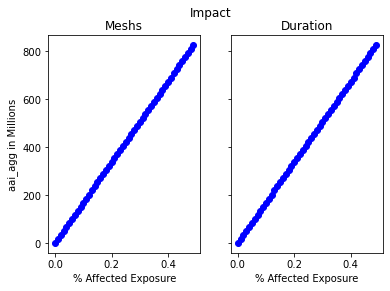

In [34]:
%matplotlib inline
fig, axs = plt.subplots(1,2, sharey=True, tight_layout = False)
fig.suptitle("Impact")
axs[0].plot(imp_fun_list, dmg_meshs_imp_list, "bo")
axs[0].set(xlabel = "% Affected Exposure", ylabel = "aai_agg in Millions", title = "Meshs")
axs[1].plot(imp_fun_list, dmg_dur_imp_list, "bo")
axs[1].set(xlabel = "% Affected Exposure", title = "Duration")



In [35]:
#Meshs
imp_fun_list_meshs = np.arange(1, 150, 1)
dmg_meshs_imp_list = []
for i in imp_fun_list_meshs:
    ifset_hail = ImpactFuncSet()
    imp_fun = fct.create_impact_func(haz_type, 
                                 10, 
                                 1, 
                                 1, 
                                 1)
    imp_fun.mdd[:] = 0
    imp_fun.mdd[i] = 1.0
    ifset_hail.append(imp_fun)

    imp_agr_meshs.calc(exp_meshs, ifset_hail, haz_real,save_mat=True)
    dmg_meshs_imp_list.append(imp_agr_meshs.aai_agg/1e6)
    

#Dur
imp_fun_list_dur = np.arange(5, 120, 5)
dmg_dur_imp_list = []
for i in imp_fun_list_dur:
    ifset_hail = ImpactFuncSet()
    imp_fun = fct.create_impact_func(haz_type, 
                                 9, 
                                 1, 
                                 1, 
                                 1)
    imp_fun.mdd[:] = 0
    imp_fun.mdd[i] = 1.0
    ifset_hail.append(imp_fun)

    imp_agr_dur.calc(exp_dur, ifset_hail, haz_dur,save_mat=True)
    dmg_dur_imp_list.append(imp_agr_dur.aai_agg/1e6)


2021-03-29 11:58:36,272 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 11:58:36,273 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 11:58:36,282 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-29 11:58:36,797 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 11:58:36,798 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 11:58:36,805 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-29 11:58:37,308 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. 

2021-03-29 11:58:45,286 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 11:58:45,294 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-29 11:58:45,912 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 11:58:45,913 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 11:58:45,920 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-29 11:58:46,633 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 11:58:46,633 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-

2021-03-29 11:58:58,765 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 11:58:58,767 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 11:58:58,775 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-29 11:58:59,410 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 11:58:59,411 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 11:58:59,419 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-29 11:59:00,043 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. 

2021-03-29 11:59:09,015 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 11:59:09,023 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-29 11:59:09,532 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 11:59:09,533 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 11:59:09,540 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-29 11:59:10,040 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 11:59:10,041 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-

2021-03-29 11:59:18,529 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 11:59:18,530 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 11:59:18,538 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-29 11:59:19,023 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 11:59:19,024 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 11:59:19,031 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-29 11:59:19,512 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. 

2021-03-29 11:59:27,460 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 11:59:27,468 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-29 11:59:27,945 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 11:59:27,946 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 11:59:27,953 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-29 11:59:28,447 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 11:59:28,448 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-

2021-03-29 11:59:36,831 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 11:59:36,831 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 11:59:36,839 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-29 11:59:37,330 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 11:59:37,331 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 11:59:37,339 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-29 11:59:37,824 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. 

2021-03-29 11:59:45,606 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 11:59:45,614 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-29 11:59:46,092 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 11:59:46,093 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 11:59:46,100 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-29 11:59:46,607 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 11:59:46,608 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-

2021-03-29 11:59:54,955 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 11:59:54,956 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 11:59:54,964 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-29 11:59:55,445 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 11:59:55,445 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 11:59:55,453 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-29 11:59:59,222 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. 

2021-03-29 12:00:12,214 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 12:00:12,222 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-29 12:00:12,846 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 12:00:12,847 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 12:00:12,855 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-29 12:00:13,468 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 12:00:13,469 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-

[Text(0.5, 0, 'Duration [min]'), Text(0.5, 1.0, 'Duration')]

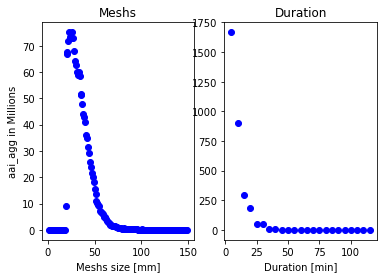

In [36]:
fig, axs = plt.subplots(1,2, sharey=False, tight_layout = False)
axs[0].plot(imp_fun_list_meshs, dmg_meshs_imp_list, "bo")
axs[1].plot(imp_fun_list_dur, dmg_dur_imp_list, "bo")
axs[0].set(xlabel = "Meshs size [mm]", ylabel = "aai_agg in Millions", title = "Meshs")
axs[1].set(xlabel = "Duration [min]", title = "Duration")


In [37]:
dmg_agr= [27.48, 46.14, 80.67, 76.80, 32.66, 62.47, 26.30, 110.60, 13.01, 34.53, 21.50, 71.77, 22.80, 19.84, 17.50, 35.80, 24.40, 33.30]
dmg_agr_angepasst = [29.12, 48.61, 84.34, 79.35, 33.37, 63.40, 26.05, 110.06, 12.87, 34.05, 21.35, 71.41, 22.71, 19.98, 17.69, 35.39, 24.30, 33.07]
dmg_agr_angepasst = [int(i*1e6) for i in dmg_agr_angepasst]

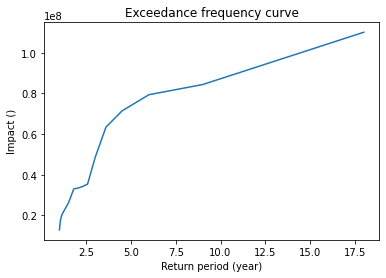

In [38]:
imp_agr = Impact()
imp_agr.at_event = np.asarray(dmg_agr_angepasst)
imp_agr.frequency = np.ones(len(imp_agr.at_event))/len(imp_agr.at_event)
imp_agr_freq_curve = imp_agr.calc_freq_curve()
imp_agr_freq_curve.plot()

In [39]:
def get_exceedance_curves_dur(which_val = 0,
                           range_q = np.arange(0,1),
                           range_m = np.arange(0.01, 0.1, 0.01)):
    # which val is for which position will all graphs be the same. 0-> first, -1 > last
    agr_val_for_fact = imp_agr_freq_curve.impact[which_val]
    freq_curve_list = []
    label = []
    for q in range_q:
        L = 1.0
        dmg_for_imp_fun_param = []
        for m in range_m:
            y = np.linspace(q, m*120, num = 120)
            ifset_hail = ImpactFuncSet()
            imp_fun = fct.create_impact_func(haz_type, 9, 1, 1, 1, y = y)
            ifset_hail.append(imp_fun)
            imp_agr_dur = Impact()
            imp_agr_dur.calc(exp_dur, ifset_hail, haz_dur,save_mat=False)
            freq_curve = imp_agr_dur.calc_freq_curve(imp_agr_freq_curve.return_per)
            freq_curve = freq_curve.impact
            L_fact = agr_val_for_fact / freq_curve[which_val]
            L *= L_fact
            #freq_curve *= L_fact
            freq_curve_list.append([freq_curve])
            rmsf = RMSF(freq_curve, imp_agr_freq_curve.impact)
            label.append("q={}, m={}, L={:2.3e}, RMSF ={:.2f}".format(q, m, L, rmsf))
    return label, freq_curve_list

In [40]:
label, freq_curve_list = get_exceedance_curves_dur(which_val = 0)

2021-03-29 12:00:16,418 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 12:00:16,420 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 12:00:16,429 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.


NameError: name 'RMSF' is not defined

In [41]:
def RMSF(X, Y):
    """
    Calculate the Root Mean Squared Fraction (RMSF)
    
    Parameters
    ----------
    X : np.ndarray
        Values from CLIMADA.
    Y : np.ndarray
        Values from observations.

    Returns
    -------
    sol : float
        Result of RMSF for X and Y.

    """
    res = 0
    for i in range(len(X)):

        res += np.log(Y[i]/X[i])**2
    res = np.exp((res/len(X))**(1/2))
    return res

2021-03-29 12:09:08,666 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 12:09:08,668 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 12:09:08,676 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-29 12:09:09,983 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-29 12:09:09,984 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-29 12:09:09,991 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-29 12:09:11,259 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. 

<IPython.core.display.Javascript object>


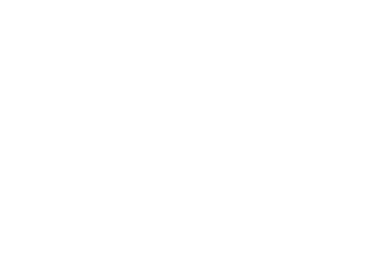

<IPython.core.display.Javascript object>


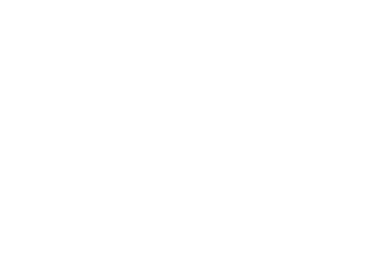

In [42]:
%matplotlib notebook
label, freq_curve_list = get_exceedance_curves_dur(which_val = 0)
for i in freq_curve_list:
    plt.plot(imp_agr_freq_curve.return_per, i[0])
plt.title("Exceedance fequency curve normalized")
plt.xlabel("Return period (year)")
plt.ylabel("Impact()")
plt.plot(imp_agr_freq_curve.return_per, imp_agr_freq_curve.impact, linewidth = 4)
label.append("VKG Data")
plt.legend(label)
plt.show()